# Select contour for circum-Antarctic isobath using plt.contour()

This script:
1. Finds a depth contour, either for the u-grid or t-grid, e.g. all points on a closed circumpolar contour at approximately 1 km depth. The resulting contour differes from the contour calculated in `*_mask_approach.ipynb` which gives us a contour where every point is connected and the values are <= contour depth.
2. Makes use of the `matplotlib.pyplot.contour` function and selects points near the contour based on the polygons calculated by the function. 
3. Allows for smoothing of the isobath prior to the contour selection.

Isobaths using this method used in ASC spatial and temporal variability project:
- 630-m isobath contour: for selection of cross-slope transects when creating the continental slope coordinate system.
- 1000-m isobath contour: to plot the along-slope velocity along the 1000-m isobath.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean as cm
import glob
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

Dask client

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35447 Dashboard: /proxy/43105/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


Database and experiment

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
exp = '01deg_jra55v13_ryf9091'

Selection of latitude range, contour depth, u-grid or t-grid, smoothing (change this according to your purpose)

In [38]:
# Latitude range
lat_range = slice(-90,-59)
# Select contour depth
contour_depth = 630
# u-grid (u) or t-grid (t)
grid_sel = 't'
# Smooting (no 0, yes 1)
smoothing = 1

## Import bathymetry (option to smooth)

In [39]:
# Function that smoothed the data in x and y direction
def running_mean_2d(in_data, N):
    in_data  = in_data.load()
    out_data = in_data.copy(deep=True)
    for yy in range(np.shape(in_data)[0]):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[yy,:], 0, 0))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)  
    for xx in range(np.shape(in_data)[1]):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[:,xx], 0, 0))
        out_data[int(N/2):-int(N/2)+1,xx] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

In [40]:
# Load lat/lon information
yt_ocean = cc.querying.getvar(exp, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(exp, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(exp, 'xt_ocean', session, n=1)
xu_ocean = cc.querying.getvar(exp, 'xu_ocean', session, n=1)

# Load bathymetry
if grid_sel == 'u':
    h = cc.querying.getvar(exp, 'hu', session, n=1)
    h = h.sel(yu_ocean=lat_range)
elif grid_sel == 't':
    h = cc.querying.getvar(exp, 'ht', session, n=1)
    h = h.sel(yt_ocean=lat_range)

# Smoothing of bathymetry
if smoothing == 1:
    h = running_mean_2d(h, 10)

# Fill in land with zeros:
h = h.fillna(0)

In [41]:
if grid_sel == 'u':
    x_var = xu_ocean
    y_var = yu_ocean
elif grid_sel == 't':
    x_var = xt_ocean
    y_var = yt_ocean

### Select the isobath contour

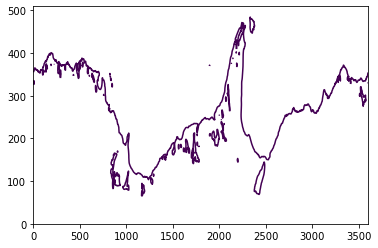

In [45]:
count = 0
x_contour = []
y_contour = []
# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        #print(np.shape(path.to_polygons()[0]))
        if count > 1: 
            # We only need the polygon from the first contour, which is the circumpolar contour
            break
        else:
            # Write down the lat/lon indices
            for ii in range(np.size(path.to_polygons()[0], 0)):
                x_contour.append(int(np.round(path.to_polygons()[0][ii][0])))
                y_contour.append(int(np.round(path.to_polygons()[0][ii][1])))

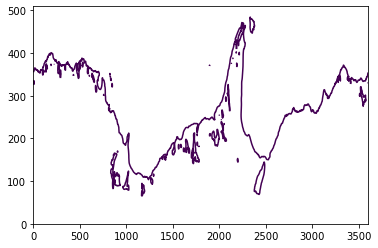

In [88]:
count = 0
x_contour = []
y_contour = []
# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        #print(np.shape(path.to_polygons()[0]))
        if count == 3:
            # For 630 m, t-grid, this is the contour we want
            # Write down the lat/lon indices
            for ii in range(np.size(path.to_polygons()[0], 0)):
                x_contour.append(int(np.round(path.to_polygons()[0][ii][0])))
                y_contour.append(int(np.round(path.to_polygons()[0][ii][1])))
        

Plot the selected values (as scatter) on top of the contour line: sanity check that we selected the correct contour.

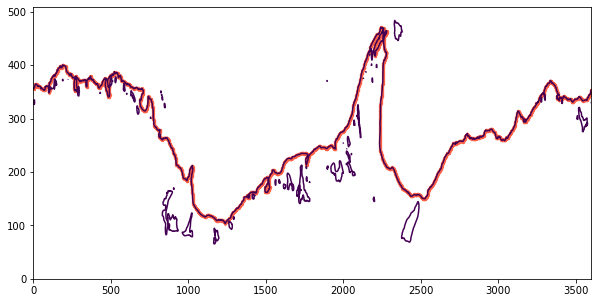

In [89]:
fig = plt.figure(figsize=(10,5))
plt.contour(h, levels=[contour_depth])
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

Remove duplicates

In [90]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)
# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [91]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

Calculate the depth for the selected contour values

In [92]:
%%time
# Takes time to run:
h_contour = np.zeros_like(x_contour)
for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

CPU times: user 619 ms, sys: 46.4 ms, total: 665 ms
Wall time: 657 ms


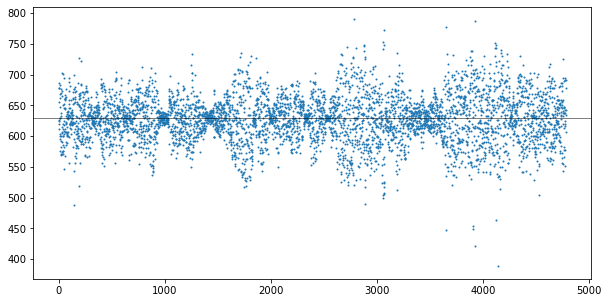

In [93]:
fig = plt.figure(figsize=(10,5))
plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

**Note**: 
- The selection is not ideal, but the maximum differences to the contour_depth is smaller than for the approach taken in `find_depth_contour_mask_approach.ipynb`
- It looks like the selected values jump around the desired contour_depth, with a varying distance depending where around the margin we are. Keep this in mind for any analysis you want to do with the data.

Remove (by hand) specific values

In [94]:
# Remove the zero values:
zero_ind = []
for ii in range(len(x_contour)):
    if h_contour[ii] <= 10:
        zero_ind.append(ii)
# Now remove the indices (start from the end so the indices don't shift)
h_contour = h_contour.tolist()
for ii in range(len(zero_ind)):
    index = zero_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]
    del h_contour[index]

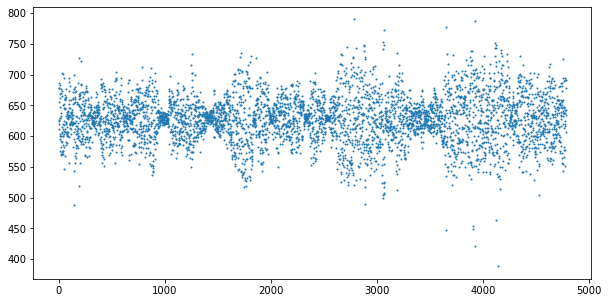

In [95]:
fig = plt.figure(figsize=(10,5))
plt.plot(h_contour, 'o', markersize=1);

## A few useful information

In [96]:
# Number of grid points on the contour
num_points = len(x_contour)

In [97]:
# Get lat and lon along the contour
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]

Distance along contour

In [98]:
def gcdist(lat1, lat2, lon1, lon2):

    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

In [99]:
distance_along_contour = np.zeros_like(lon_along_contour)
for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    distance_along_contour[ii+1] = gcdist(lat1, lat2, lon1, lon2)
distance_along_contour = distance_along_contour.cumsum()

## Save

Run the script for the u-grid and as well as the t-grid and then save both together.

In [100]:
if grid_sel == 'u':
    #contour_mask_numbered_u  = contour_mask_numbered
    #contour_masked_above_u   = contour_masked_above
    num_points_u             = num_points
    lon_along_contour_u      = lon_along_contour
    lat_along_contour_u      = lat_along_contour
    distance_along_contour_u = distance_along_contour
    h_contour_u              = h_contour
    x_index_u                = x_contour
    y_index_u                = y_contour
elif grid_sel == 't':
    #contour_mask_numbered_t  = contour_mask_numbered
    #contour_masked_above_t   = contour_masked_above
    num_points_t             = num_points
    lon_along_contour_t      = lon_along_contour
    lat_along_contour_t      = lat_along_contour
    distance_along_contour_t = distance_along_contour
    h_contour_t              = h_contour
    x_index_t                = x_contour
    y_index_t                = y_contour

---
Run this last cell once you run the above for both the u-grid and the t-grid.

In [101]:
import os
save_dir = '/g/data/x77/wgh581/Post_Process/'
if smoothing == 0:
    outfile = os.path.join(save_dir,'Antarctic_slope_contour_u_t_'+str(contour_depth)+'m_plt_approach.npz')
elif smoothing == 1:
    outfile = os.path.join(save_dir,'Antarctic_slope_contour_smoothed_u_t_'+str(contour_depth)+'m_plt_approach.npz')

np.savez(outfile, contour_depth=contour_depth, 
    h_contour_u=h_contour_u, h_contour_t=h_contour_t, xt_ocean=xt_ocean, yt_ocean=yt_ocean,
    num_points_u=num_points_u, num_points_t=num_points_t, 
    x_index_u=x_index_u, y_index_u=y_index_u, x_index_t=x_index_t, y_index_t=y_index_t,
    distance_along_contour_u=distance_along_contour_u, distance_along_contour_t=distance_along_contour_t,
    lon_along_contour_u=lon_along_contour_u, lat_along_contour_u=lat_along_contour_u,
    lon_along_contour_t=lon_along_contour_t, lat_along_contour_t=lat_along_contour_t)